# [GD-10] 도로 영역을 찾자!
### 목차
1. KITTI 데이터셋 수집과 구축
2. U-Net 모델의 구현
3. U-Net++ 모델의 구현
4. U-Net과 U-Net++ 모델이 수행한 segmentation 결과 분석
    1. 시각화
    2. IoU
5. 회고

---
### 루브릭 평가 기준
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
    * KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?
    * U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
    * U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

## 1. KITTI 데이터셋 수집과 구축

In [26]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [7]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

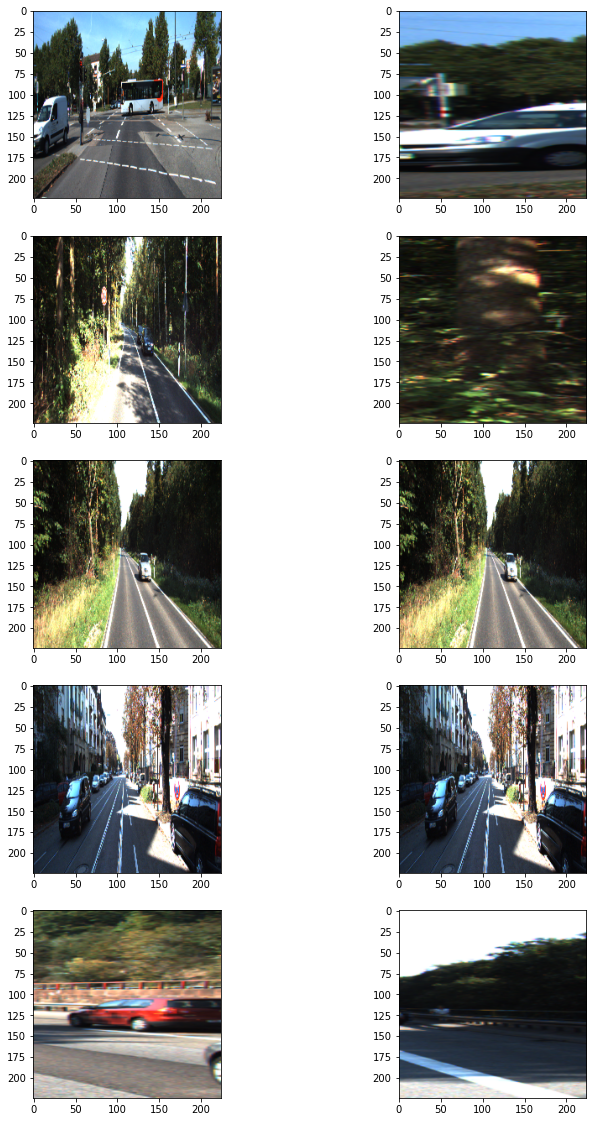

In [8]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 2. U-Net 모델의 구현

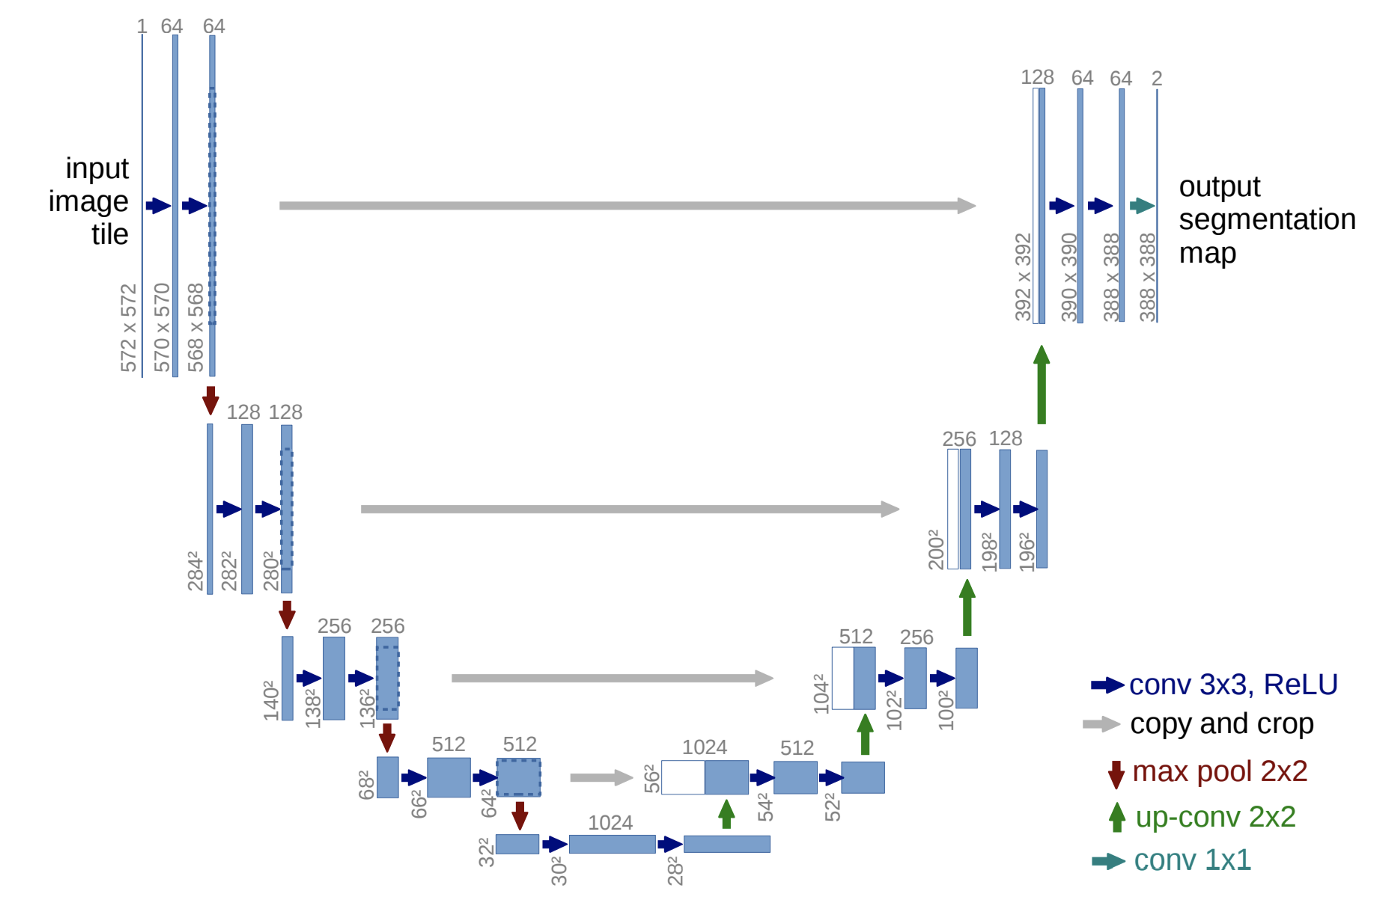

* U-Net은 초기에 의학 분야에서 image segmentation을 목적으로 제안된 end-to-end 방식의 Fully-Convolutional Network 기반 모델이다.
* Network 구성이 'U'자 형태로 되어있어, U-Net이라는 이름이 붙여졌다.
* U-Net은 크게 두 가지 path로 구성되어 있는데, down-sampling을 진행하는 'Contracting Path'와 up-sampling을 진행하는 Expansive Path이다.
* 또한, U-Net은 FCN의 skip connection 개념도 활용하여, 얕은 층의 feature map을 깊은 층의 feature map과 결합하는 방식을 제안했다.
* down-sampling을 진행한 후 다시 up-sampling을 진행하면, 정교한 픽셀 정보가 사라지게 된다. 이는 픽셀 단위로 조밀한 예측이 필요한 segmentation에서 큰 문제가 된다. 따라서, contracting path에서 expansive path로 중요 정보를 직접 넘겨주는 skip connection을 통해 expansive path에서 훨씬 더 선명한 이미지를 결과를 얻게 됨에 따라 더 정확한 예측이 가능하게 된다.


In [11]:
def build_unet_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    # Expansive path
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv5)
    merge6 = concatenate([drop4,up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [12]:
unet = build_unet_model()
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
unet_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet.save(unet_path)  #학습한 모델을 저장해 주세요.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 59s 663ms/step - loss: 0.5939 - val_loss: 0.1231
Epoch 2/100
43/43 [==============================] - 28s 647ms/step - loss: 0.1298 - val_loss: 0.0943
Epoch 3/100
43/43 [==============================] - 28s 648ms/step - loss: 0.0816 - val_loss: 0.0928
Epoch 4/100
43/43 [==============================] - 28s 649ms/step - loss: 0.0845 - val_loss: 0.0764
Epoch 5/100
43/43 [==============================] - 28s 649ms/step - loss: 0.0828 - val_loss: 0.0849
Epoch 6/100
43/43 [==============================] - 28s 650ms/step - loss: 0.0793 - val_loss: 0.0805
Epoch 7/100
43/43 [==============================] - 28s 653ms/step - loss: 0.0712 - val_loss: 0.0927
Epoch 8/100
43/43 [==============================] - 28s 654ms/step - loss: 0.0864 - val_loss: 0.1231
Epoch 9/100
43/43 [==============================] - 28s 653ms/step - loss: 0.1170 - val_loss: 0.1157
Epoch 10/100
43/43 [==============================] - 28s 657ms/step - loss: 0.148

## 3. U-Net++ 모델의 구현

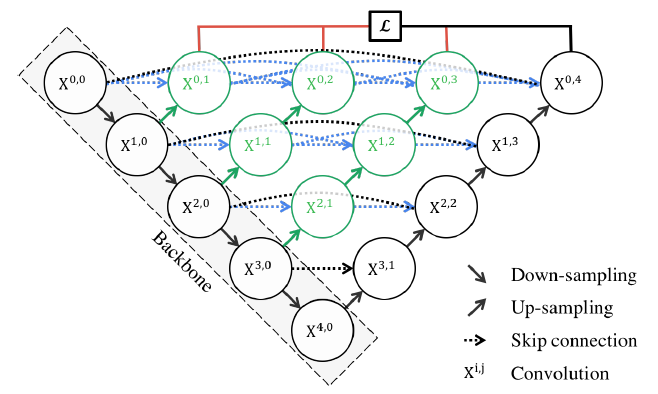
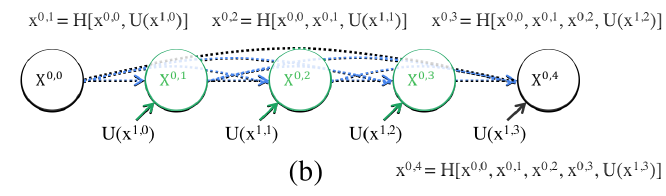

* Image segmentation 분야에서 FCN, U-Net 모델들이 성능이 좋았던 이유는 skip connection 때문이다. 즉, skip connection을 이용하면, image의 세부 정보를 복구하는데 효과적이다는 것은 입증되었다.
* 그러나, 다음과 같은 문제들이 존재
    1. 일반 사물들을 대상으로 분류하는 Mask-RCNN model에서도 "skip connection"을 사용하여 좋은 성능을 달성했다. 하지만, 의료 이미지처럼 엄격한 데이터를 segmentation 하는데 있어서 요구사항을 충족할지 의문을 남김
    2. 의료 영상에서 Segmenting lesions 또는 abnormalities를 분할하려면, 기존 모델 대비(e.g. U-net)하여 **높은 수준의 정확도**를 필요로 함
* 높은 정확도를 얻기 위해, a new segmentation architecture based on nested and desne skip connection 의 U-net++를 제안

---

* 위 그림을 보면, Unet++은 an encoder sub-network(or backbone)으로 시작해서, a decoder sub-network로 끝나게 된다. (black으로 표현된 U자형 구조는 기존 U-Net과 동일함) 하지만, U-Net++에서는 U자형 구조 안안에 있는 skip-connection (skip pathways : green / blue)의 방법과 deep supervision (red)이 재설계되었음을 알 수 있다.

---

* Reference
* https://daljoong2.tistory.com/179
* https://github.com/CarryHJR/Nested-UNet
* https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py

In [4]:
def build_unetpp_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # x 0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2,2))(conv0_0)
    
    # x 1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2,2))(conv1_0)
    
    # x 2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2,2))(conv2_0)
    
    # x 3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2,2))(conv3_0)
    
    # x 4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3_0)
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_0)
    
    # x 0,1
    up1_0 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_0)
    merge0_1 = concatenate([up1_0, conv0_0], axis=3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_1)
    
    # x 1,1
    up2_0 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_0)
    merge1_1 = concatenate([up2_0, conv1_0], axis=3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_1)
    
    # x 2,1
    up3_0 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_0)
    merge2_1 = concatenate([up3_0, conv2_0], axis=3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_1)
    
    # x 3,1
    up4_0 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_0)
    merge3_1 = concatenate([up4_0, conv3_0], axis=3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_1)
    
    # x 0,2
    up1_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_1)
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis=3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_2)
    
    # x 1,2
    up2_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    merge1_2 = concatenate([up2_1, conv1_0, conv1_1], axis=3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)
    
    # x 2,2
    up3_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis=3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)
    
    # x 0,3
    up1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_2)
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis=3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_3)
    
    # x 1,3
    up2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis=3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)
    
    # x 0,4
    up1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_3)
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis=3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_4)
    
    # output
    conv_output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    
    model = Model(inputs = inputs, outputs = conv_output)
    
    return model

In [ ]:
## deep supervision이 추가된 U-Net++ architecture
# def build_unetpp_model(input_shape=(224, 224, 3), deep_supervision=False):
#     inputs = Input(input_shape)
    
#     # x 0,0
#     conv0_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
#     conv0_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_0)
#     pool0_0 = MaxPooling2D(pool_size=(2,2))(conv0_0)
    
#     # x 1,0
#     conv1_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool0_0)
#     conv1_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_0)
#     pool1_0 = MaxPooling2D(pool_size=(2,2))(conv1_0)
    
#     # x 2,0
#     conv2_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1_0)
#     conv2_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_0)
#     pool2_0 = MaxPooling2D(pool_size=(2,2))(conv2_0)
    
#     # x 3,0
#     conv3_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2_0)
#     conv3_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_0)
#     pool3_0 = MaxPooling2D(pool_size=(2,2))(conv3_0)
    
#     # x 4,0
#     conv4_0 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3_0)
#     conv4_0 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_0)
    
#     # x 0,1
#     up1_0 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_0)
#     merge0_1 = concatenate([up1_0, conv0_0], axis=3)
#     conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_1)
#     conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_1)
    
#     # x 1,1
#     up2_0 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_0)
#     merge1_1 = concatenate([up2_0, conv1_0], axis=3)
#     conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_1)
#     conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_1)
    
#     # x 2,1
#     up3_0 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_0)
#     merge2_1 = concatenate([up3_0, conv2_0], axis=3)
#     conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_1)
#     conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_1)
    
#     # x 3,1
#     up4_0 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_0)
#     merge3_1 = concatenate([up4_0, conv3_0], axis=3)
#     conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3_1)
#     conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_1)
    
#     # x 0,2
#     up1_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_1)
#     merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis=3)
#     conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_2)
#     conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_2)
    
#     # x 1,2
#     up2_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
#     merge1_2 = concatenate([up2_1, conv1_0, conv1_1], axis=3)
#     conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_2)
#     conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)
    
#     # x 2,2
#     up3_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
#     merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis=3)
#     conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_2)
#     conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)
    
#     # x 0,3
#     up1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_2)
#     merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis=3)
#     conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_3)
#     conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_3)
    
#     # x 1,3
#     up2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
#     merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis=3)
#     conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_3)
#     conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)
    
#     # x 0,4
#     up1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_3)
#     merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis=3)
#     conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_4)
#     conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_4)
    
#     # output
#     output_1 = Conv2D(1, 1, activation='sigmoid')(conv0_1)
#     output_2 = Conv2D(1, 1, activation='sigmoid')(conv0_2)
#     output_3 = Conv2D(1, 1, activation='sigmoid')(conv0_3)
#     output_4 = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    
#     if deep_supervision:
#         model = Model(inputs=inputs, outputs=[output_1,
#                                              output_2,
#                                              output_3,
#                                              output_4])
#     else:
#         model = Model(inputs = inputs, outputs = output_4)
    
#     return model

In [5]:
unetpp = build_unetpp_model()
unetpp.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
unetpp_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

unetpp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unetpp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unetpp.save(unetpp_path)  #학습한 모델을 저장해 주세요.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 118s 2s/step - loss: 0.5792 - val_loss: 0.1683
Epoch 2/100
43/43 [==============================] - 72s 2s/step - loss: 0.1184 - val_loss: 0.0913
Epoch 3/100
43/43 [==============================] - 72s 2s/step - loss: 0.0932 - val_loss: 0.0823
Epoch 4/100
43/43 [==============================] - 72s 2s/step - loss: 0.1004 - val_loss: 0.0996
Epoch 5/100
43/43 [==============================] - 72s 2s/step - loss: 0.0975 - val_loss: 0.0788
Epoch 6/100
43/43 [==============================] - 71s 2s/step - loss: 0.0797 - val_loss: 0.0860
Epoch 7/100
43/43 [==============================] - 71s 2s/step - loss: 0.0544 - val_loss: 0.0684
Epoch 8/100
43/43 [==============================] - 71s 2s/step - loss: 0.0538 - val_loss: 0.0612
Epoch 9/100
43/43 [==============================] - 71s 2s/step - loss: 0.0520 - val_loss: 0.0630
Epoch 10/100
43/43 [==============================] - 72s 2s/step - loss: 0.0598 - val_loss: 0.0582
Epoch 11

## 4. U-Net과 U-Net++ 모델이 수행한 segmentation 결과 분석

### 4.1 시각화

In [14]:
unet_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
unetpp_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

unet = tf.keras.models.load_model(unet_path)
unetpp = tf.keras.models.load_model(unetpp_path)

In [16]:
def get_output(model, preproc, image_path, output_path):
    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

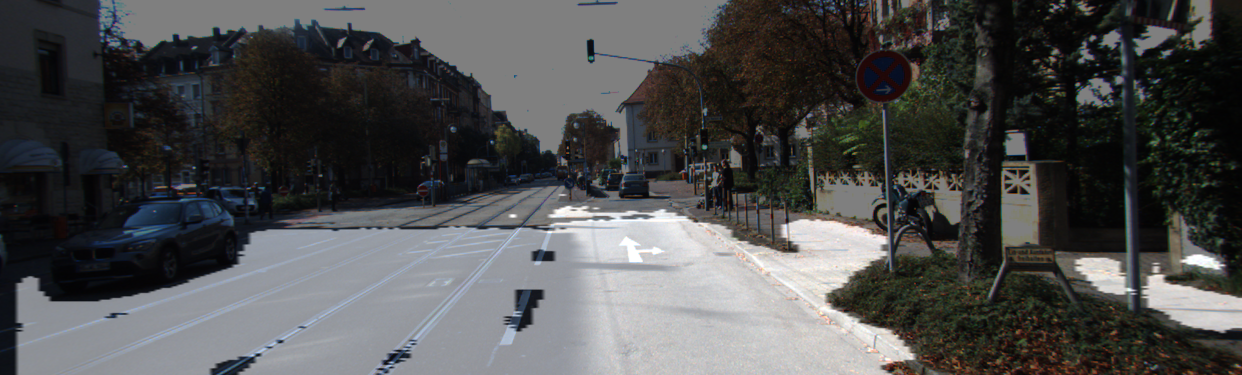

In [17]:
# U-Net segmentation image test
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

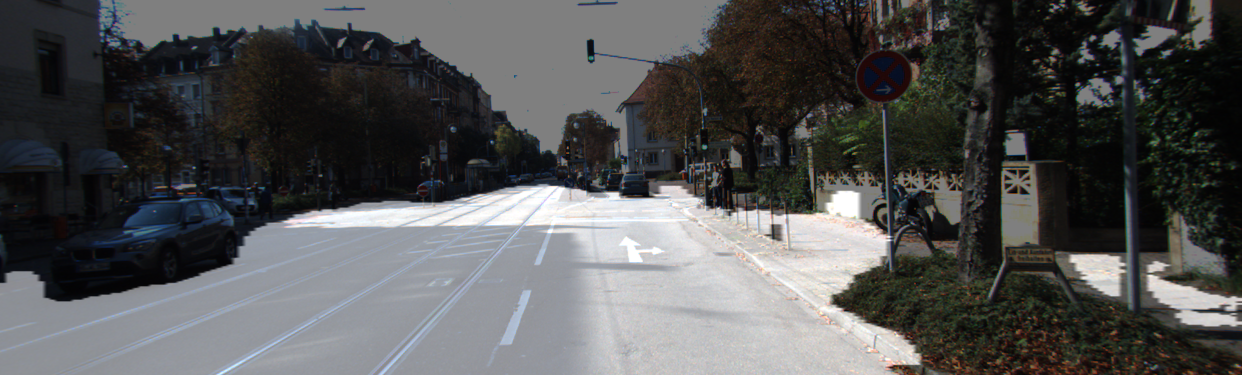

In [18]:
# U-Net++ segmentation image test
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### 4.2 IoU

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [20]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [22]:
# U-Net IoU
unet_iou = []

for i in range(50):
    output, prediction, target = get_output(
         unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou_score(target, prediction))

IoU : 0.743685
IoU : 0.764467
IoU : 0.669394
IoU : 0.629294
IoU : 0.631091
IoU : 0.560253
IoU : 0.393192
IoU : 0.750018
IoU : 0.704491
IoU : 0.704433
IoU : 0.764183
IoU : 0.783906
IoU : 0.686494
IoU : 0.788364
IoU : 0.738993
IoU : 0.802659
IoU : 0.841384
IoU : 0.851552
IoU : 0.627449
IoU : 0.623335
IoU : 0.738844
IoU : 0.538421
IoU : 0.835876
IoU : 0.851189
IoU : 0.715349
IoU : 0.583935
IoU : 0.575145
IoU : 0.739233
IoU : 0.786044
IoU : 0.773303
IoU : 0.768123
IoU : 0.739560
IoU : 0.682301
IoU : 0.776759
IoU : 0.609158
IoU : 0.890821
IoU : 0.862113
IoU : 0.843898
IoU : 0.829633
IoU : 0.835920
IoU : 0.872745
IoU : 0.849517
IoU : 0.828560
IoU : 0.808917
IoU : 0.812558
IoU : 0.788426
IoU : 0.797740
IoU : 0.754531
IoU : 0.728121
IoU : 0.663714


In [23]:
# U-Net++ IoU
unetpp_iou = []

for i in range(50):
    output, prediction, target = get_output(
         unetpp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unetpp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.922000
IoU : 0.830287
IoU : 0.637671
IoU : 0.667711
IoU : 0.704863
IoU : 0.723975
IoU : 0.593856
IoU : 0.852138
IoU : 0.816962
IoU : 0.781012
IoU : 0.815354
IoU : 0.821654
IoU : 0.777610
IoU : 0.875561
IoU : 0.898015
IoU : 0.887951
IoU : 0.897260
IoU : 0.897603
IoU : 0.774602
IoU : 0.842742
IoU : 0.827803
IoU : 0.644031
IoU : 0.856250
IoU : 0.836761
IoU : 0.697065
IoU : 0.591313
IoU : 0.566368
IoU : 0.780539
IoU : 0.821315
IoU : 0.799643
IoU : 0.800685
IoU : 0.765901
IoU : 0.721140
IoU : 0.775917
IoU : 0.654502
IoU : 0.926395
IoU : 0.939136
IoU : 0.874424
IoU : 0.879569
IoU : 0.929330
IoU : 0.945241
IoU : 0.922129
IoU : 0.911399
IoU : 0.852227
IoU : 0.845180
IoU : 0.849757
IoU : 0.836107
IoU : 0.845147
IoU : 0.827270
IoU : 0.794474


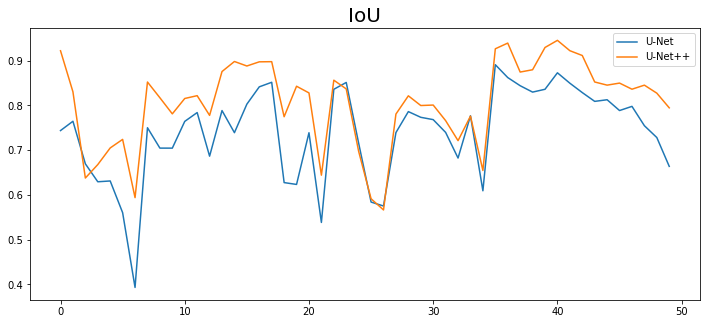

In [24]:
plt.figure(figsize=(12,5))
plt.plot(unet_iou)
plt.plot(unetpp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

In [27]:
df_iou = pd.DataFrame({'U-Net': unet_iou,
                       'U-Net++': unetpp_iou})
df_iou.mean()

U-Net      0.738782
U-Net++    0.806717
dtype: float64

## 5. 회고

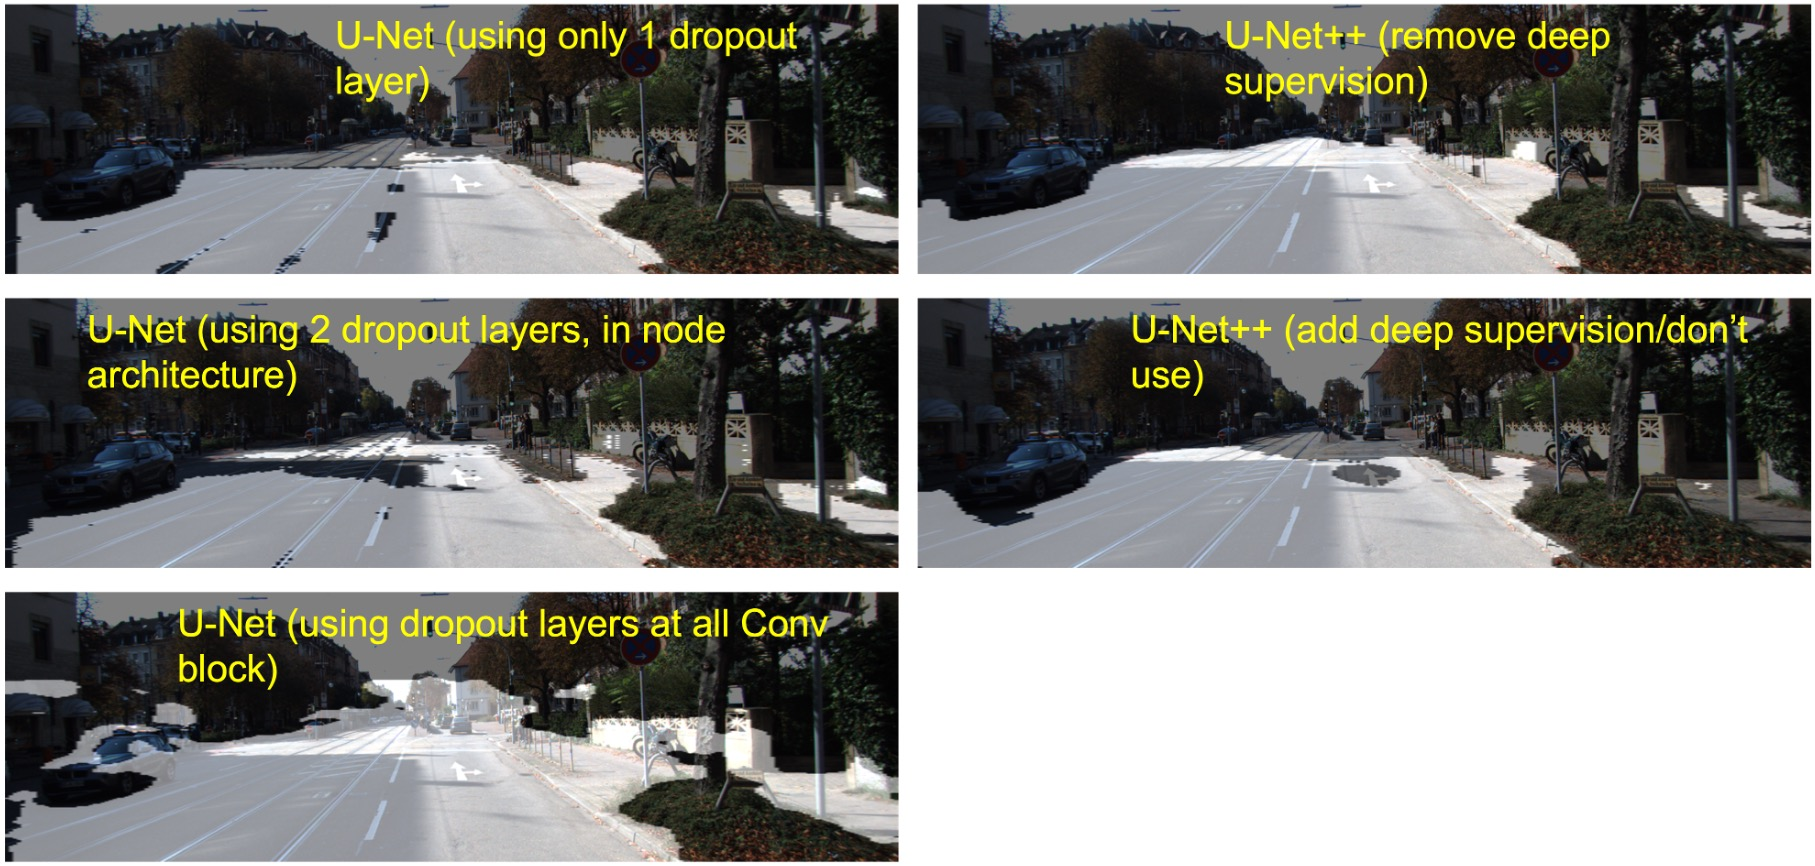

|Architecture|IoU|
|---|---|
|**U-Net (using only 1 dropout layer)**|**0.7388**|
|U-Net (using 2 dropout layers, in node architecture)|0.7129|
|U-Net (using dropout layers at all conv block)|0.6060|
|**U-Net++ (remove deep supervision part)**|**0.8067**|
|U-Net++ (add deep supervision part/don't use deep supervision)|0.7467|

* U-Net의 경우, 논문에서 Contracting path의 마지막에서 dropout layer를 수행한다고 언급했다. 나는 이 내용으로, U-Net에서 dropout layer가 단 한번 존재한다고 판단했다. 따라서, 처음에는 Contracting path의 마지막에만 dropout layer를 이용한 모델을 설계했다. 그러나, 노드에 있는 정답 코드에서는 dropout layer를 두번 사용하는 것을 확인했고, U-Net에 대해 찾아보던 중, 모든 Conv block에서 dropout을 사용한 코드를 보았다. 나는 각각의 모델의 성능 차이를 확인하고자 했고, 어떤 architecture가 가장 좋은 성능을 보이는지 확인했다. IoU가 가장 높은 모델은 내가 처음에 설계했던 dropout layer를 한번만 사용한 모델이었다. dropout layer를 두번 사용한 모델과 IoU 차이가 크지는 않았지만, 약간의 성능 향상을 위해서 dropout layer를 줄이는 것 또한 의미있는 과정이라고 생각한다. 그러나, dropout layer의 목적을 생각해본다면, overfitting에 대한 확인이 필요하다고 생각한다. (모든 Conv block에서 dropout layer를 사용한 것은 당연히 성능이 매우 낮았다.)
* U-Net++의 경우, deep supervision part를 추가한 architecture와 추가하지 않은 architecture를 설계했다. deep supervision을 추가한 architecture의 경우, deep supervision을 사용하여 학습한 결과를 첨부하지 못했는데, 이 부분은 추후에 추가할 예정이다. 그러나 한 가지 의문점은, 단순히 deep supervision을 사용할때 출력되는 output 부분만 변경한 architecture인데, IoU 값이 이렇게 많이 차이난다는 것이 이해되지 않는다. 이 부분은 추후에 모델을 다시 학습시켜 확인할 예정이다. 어쨌든, U-Net++가 U-Net보다 좋은 성능을 보이는 것은 확실하다. 출력된 segmentation 결과를 확인해봐도, U-Net++가 더 좋은 성능을 보이는 것을 확인할 수 있다.

---

* semantic segmentation을 위한 U-Net과 U-Net++ 모델을 설계하고 학습하는 내용의 노드였다. 이전에 U-Net 논문인 **'U-Net: Convolutional Networks for Biomedical Image Segmentation' ([link](https://arxiv.org/pdf/1505.04597.pdf))**를 읽었기에, 비교적 쉽게 노드를 진행했다.

---

* **U-Net**은 논문 제목에서 확인할 수 있듯이, biomedical 분야에서 image segmentation을 목적으로 제안된 모델로, End-to-End 방식의 Fully-Convolutional Network 기반 모델이다. 네트워크 구성 형태('U')로 인해 U-Net이라는 이름이 붙었다. U-Net은 이미지의 전반적인 context 정보를 얻기 위한 network와 localization을 위한 network가 대칭 형태로 구성되어 있다. 이미지의 down-sampling을 통해 context를 포착하는 부분을 **Contracting path**라 부르고, feature map의 up-sampling 과정과 함께 Contracting path에서 포착한 feature map의 context와 결합하여 더 정확한 localization을 하는 부분을 **Expansive path**라고 부른다.

---

* **U-Net++**는 DenseNet의 **Dense block** 아이디어를 사용하여 U-Net을 향상시킨 것이다. 기존의 U-Net과의 차이점은 다음과 같다.

    1. skip connection에 convolution층이 있다는 것. 이는 encoder와 decoder feature map 사이의 semantic gap을 연결해줌
    2. skip connection에 dense skip이 존재. 이는 기울기의 흐름을 향상시킴
    3. 모델 가지치기 그리고 향상이 가능하게 하거나 최악의 경우 하나의 loss 층만을 사용하것과 유사한 성능을 달성하는 deep supervision이 존재
  
  
    
* **U-Net++**는 U-Net과 마찬가지로 down-sampling 후 up-sampling이 진행된다. U-Net에 존재하는 skip connection도 마찬가지로 U-Net++에 존재하는데, 하나의 block에 대해서만 skip connection이 되는 것이 아니라, 여러개의 skip connection을 통해서 여러 block의 feature map의 context를 결합한다는 차이가 존재한다.(DenseNet에서 착안해 온 아이디어) 또한, **deep supervision**이 존재하는데, 모든 segmentation branche들로 부터 출력된 아웃풋의 평균화하는 정확한 모드나 nal segmentation map이 segmentation branche 중 한 개를 선택하는 빠른모드로서, 그러한 선택은 모델 pruning정도와 속도 이득에 영향을 준다. 
